In [1]:
from cocpit import config as config
import cocpit
import numpy as np
import shap
import os
import torch
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [2]:
# get val loader
device = config.DEVICE
model = torch.load(config.MODEL_SAVENAME).to(device)
model.eval()

val_data = torch.load(config.VAL_LOADER_SAVENAME)
val_loader = cocpit.data_loaders.create_loader(val_data, batch_size=10, sampler=None)

In [4]:
# get test loader
open_dir = '/ai2es/test_set/shap'
file_list = os.listdir(open_dir)
test_data = cocpit.data_loaders.TestDataSet(open_dir, file_list)
test_loader = cocpit.data_loaders.create_loader(test_data, batch_size=10, sampler=None)

In [5]:
batch = next(iter(val_loader))
(background_images, _, _), _ = batch
background = background_images.to(device)

In [6]:
batch = next(iter(test_loader))
test_images, path = batch
test_images = test_images.to(device)

In [7]:
from torchvision import transforms, models, datasets

model1 = models.vgg16(pretrained=True).eval()
model1 = model1.to(device)

e = shap.GradientExplainer((model1, model1.features[7]), background)


In [12]:
test_images.shape, background.shape

(torch.Size([9, 3, 224, 224]), torch.Size([10, 3, 224, 224]))

In [13]:
shap_values, indexes = e.shap_values(test_images)

In [35]:
e = shap.GradientExplainer((model, model.module.features._modules['40']), background)


AttributeError: 'Conv2d' object has no attribute 'target_input'

In [10]:
indexes

tensor([[562, 818, 904],
        [818, 900, 657],
        [421, 905, 743],
        [562, 904, 425],
        [421, 743, 716],
        [900, 437, 657],
        [818, 794, 562],
        [716, 562, 525],
        [489, 562, 818]], device='cuda:0')

In [9]:
labels = []
for img in indexes.cpu():
    labels.extend(config.CLASS_NAMES[img[c]] for c, label in enumerate(img))
labels_trans = np.reshape(labels, np.shape(indexes.cpu()))

IndexError: list index out of range

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
test_images = np.transpose(test_images.cpu().numpy(), (0,2,3,1))

In [9]:
np.shape(sv_transposed), np.shape(scaled)

((3, 9, 224, 224, 3), (9, 224, 224, 3))

In [7]:
scaled = [NormalizeData(i) for i in test_images]
scaled = np.resize(scaled, np.shape(test_images))
sv_transposed = [shap_value.transpose(0, 2, 3, 1) for shap_value in shap_values]
# sv_up = [cv2.resize(
#             i, (500,500)
#         ) for i in sv_transposed[1]]
# scaled_up = [cv2.resize(
#             i, (500,500)
#         ) for i in test_images]


In [ ]:
fig, axs = plt.subplots(nrows=9, ncols=4, figsize=(20, 30))
axs[i]

In [42]:
sv_up = []
sv_transposed = np.array(sv_transposed)
for i in range(np.shape(sv_transposed)[0]):
    for j in range(np.shape(sv_transposed)[1]):
        sv_up.append([cv2.resize(sv_transposed[i,j,:,:,:], (500,500))])
sv_up = np.array(sv_up).resize(np.shape(sv_transposed))
sv_up

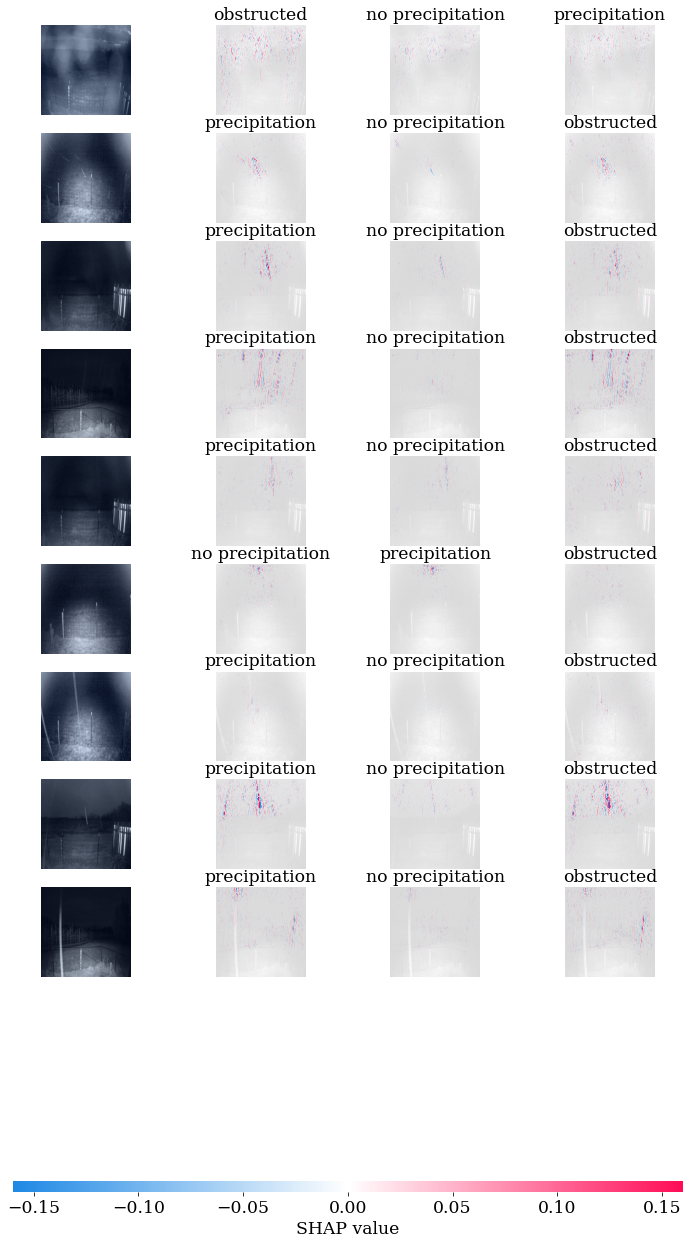

In [8]:
shap.image_plot(sv_transposed, scaled, labels=labels_trans)